In [24]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torchaudio
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
# https://www.kaggle.com/karthik999/pytorch-human-speech-classification

In [28]:
num_epochs = 50
num_classes = 2
batch_size = 5
learning_rate = 0.000001
sample_rate = 16000


In [1]:
modality = {'01':'full_av','02':'video_only','03':'audio_only'}
vocal_channel = {'01':'speech','02':'song'}
emotion = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
emotional_intensity = {'01':'normal','02':'strong'}
statement = {'01':'Kids are talking by the door','02':'Dogs are sitting by the door'}
reptition = {'01':'first_repitition','02':'second_repetition'}
def actor_f(num):
    if int(num)%2==0: return('female')
    else: return('male')

In [3]:
actors = sorted(os.listdir('/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24'))
actors.pop()
actors

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23']

In [4]:
audio_file_dict = {}
for actor in actors:
    actor_dir = os.path.join('/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24',actor)
    actor_files = os.listdir(actor_dir)
    actor_dict = [i.replace(".wav","").split("-") for i in actor_files]
    dict_entry = {os.path.join(actor_dir,i):j for i,j in zip(actor_files,actor_dict)}
    audio_file_dict.update(dict_entry)

In [5]:
audio_file_dict = pd.DataFrame(audio_file_dict).T
audio_file_dict.columns = ['modality','vocal_channel','emotion','emotional_intensity','statement','repetition','actor']
audio_file_dict

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-08-02-02-01-01.wav,03,01,08,02,02,01,01
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-08-01-01-01-01.wav,03,01,08,01,01,01,01
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-05-01-02-01-01.wav,03,01,05,01,02,01,01
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-06-01-02-02-01.wav,03,01,06,01,02,02,01
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-06-02-01-02-01.wav,03,01,06,02,01,02,01
...,...,...,...,...,...,...,...
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-03-02-02-02-23.wav,03,01,03,02,02,02,23
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-03-01-01-02-23.wav,03,01,03,01,01,02,23
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-02-02-01-01-23.wav,03,01,02,02,01,01,23
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-02-01-02-01-23.wav,03,01,02,01,02,01,23


In [6]:
audio_file_dict.modality = audio_file_dict.modality.map(modality)
audio_file_dict.vocal_channel = audio_file_dict.vocal_channel.map(vocal_channel)
audio_file_dict.emotion = audio_file_dict.emotion.map(emotion)
audio_file_dict.emotional_intensity = audio_file_dict.emotional_intensity.map(emotional_intensity)
audio_file_dict.statement = audio_file_dict.statement.map(statement)
audio_file_dict.repetition = audio_file_dict.repetition.map(reptition)
audio_file_dict['actor_sex'] = audio_file_dict.actor.apply(actor_f)

In [7]:
audio_file_dict

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,actor_sex
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-08-02-02-01-01.wav,audio_only,speech,surprised,strong,Dogs are sitting by the door,first_repitition,01,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-08-01-01-01-01.wav,audio_only,speech,surprised,normal,Kids are talking by the door,first_repitition,01,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-05-01-02-01-01.wav,audio_only,speech,angry,normal,Dogs are sitting by the door,first_repitition,01,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-06-01-02-02-01.wav,audio_only,speech,fearful,normal,Dogs are sitting by the door,second_repetition,01,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-06-02-01-02-01.wav,audio_only,speech,fearful,strong,Kids are talking by the door,second_repetition,01,male
...,...,...,...,...,...,...,...,...
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-03-02-02-02-23.wav,audio_only,speech,happy,strong,Dogs are sitting by the door,second_repetition,23,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-03-01-01-02-23.wav,audio_only,speech,happy,normal,Kids are talking by the door,second_repetition,23,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-02-02-01-01-23.wav,audio_only,speech,calm,strong,Kids are talking by the door,first_repitition,23,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-02-01-02-01-23.wav,audio_only,speech,calm,normal,Dogs are sitting by the door,first_repitition,23,male


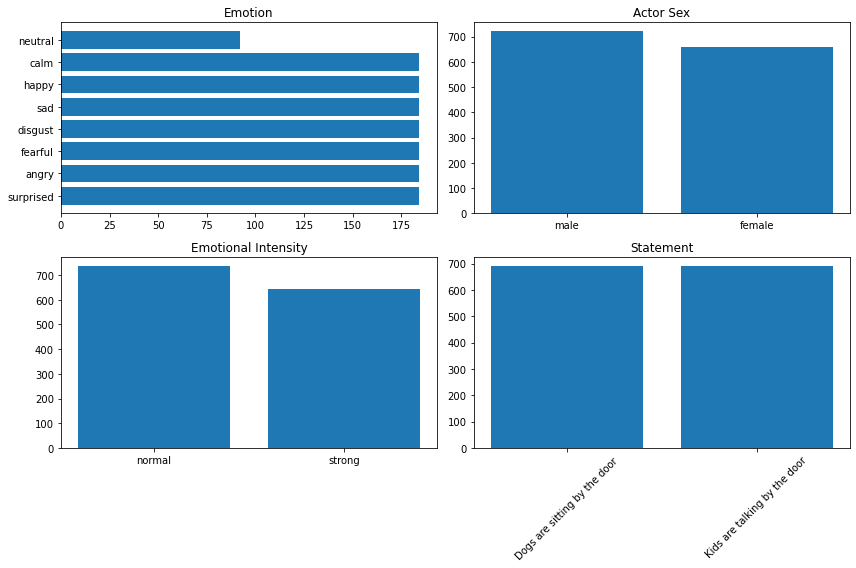

In [10]:
fig, (ax1,ax2) = plt.subplots(2, 2,figsize=(12,8))
ax1[0].barh(y=audio_file_dict.emotion.value_counts().index,width=audio_file_dict.emotion.value_counts().values)
ax1[0].set_title('Emotion')
ax1[1].bar(x=audio_file_dict.actor_sex.value_counts().index,height=audio_file_dict.actor_sex.value_counts().values)
ax1[1].set_title('Actor Sex')
ax2[0].bar(x=audio_file_dict.emotional_intensity.value_counts().index,height=audio_file_dict.emotional_intensity.value_counts().values)
ax2[0].set_title('Emotional Intensity')
ax2[1].bar(x=audio_file_dict.statement.value_counts().index,height=audio_file_dict.statement.value_counts().values)
plt.xticks(rotation=45)
ax2[1].set_title('Statement')
fig.tight_layout() 


In [12]:
sample1, sample_rate1 = torchaudio.load('/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')
sample1, sample_rate1

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 48000)

In [15]:
sample2, sample_rate2 = torchaudio.load('/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-02-01.wav')
sample2, sample_rate2

(tensor([[ 0.0000e+00,  0.0000e+00, -3.0518e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 48000)

In [17]:
sample1.shape

torch.Size([1, 158558])

In [18]:
sample2.shape

torch.Size([1, 160160])

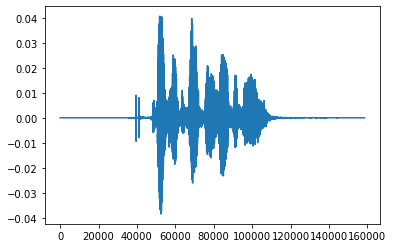

In [19]:
plt.plot(sample1.t().numpy())

Shape of spectrogram: torch.Size([1, 201, 793])


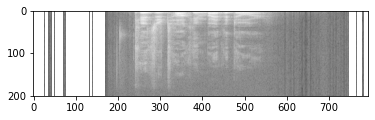

In [36]:
audio_files = []
for i in list(audio_file_dict.index):
    i, _ = torchaudio.load(i)
    audio_files.append(i)


maxlen = 0
minlen = np.Inf
for i in audio_files:
    if i.shape[1]>maxlen:
        maxlen = i.shape[1]
    if i.shape[1]<minlen:
        minlen = i.shape[1]
specgram = torchaudio.transforms.Spectrogram()(sample1)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

spectrograms = []
for i in audio_files:
    specgram = torchaudio.transforms.Spectrogram()(i)
    spectrograms.append(specgram)

In [37]:
spectrograms[0].shape,spectrograms[1].shape,spectrograms[2].shape,


(torch.Size([1, 201, 841]),
 torch.Size([1, 201, 817]),
 torch.Size([1, 201, 841]))

In [38]:
max_width, max_height = max([i.shape[2] for i in spectrograms]), max([i.shape[1] for i in spectrograms])

In [39]:
image_batch = [
    # The needed padding is the difference between the
    # max width/height and the image's actual width/height.
    F.pad(img, [0, max_width - img.size(2), 0, max_height - img.size(1)])
    for img in spectrograms
]

In [40]:
image_batch[0].shape, image_batch[1].shape, image_batch[2].shape,

(torch.Size([1, 201, 1266]),
 torch.Size([1, 201, 1266]),
 torch.Size([1, 201, 1266]))

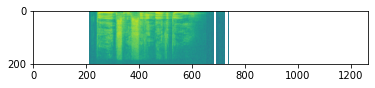

In [41]:
plt.imshow(image_batch[0][0].log2())


In [42]:
image_batch = torch.cat(image_batch,0)

In [43]:
del audio_files, spectrograms

In [44]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, audio_file_dict):
        self.audio_file_dict = audio_file_dict.reset_index()

    def __getitem__(self, index):
            img = self.audio_file_dict.reset_index()['index'][index]
            img, _ = torchaudio.load(img)
            img = torch.mean(img, dim=0).unsqueeze(0)
            img = torchaudio.transforms.Spectrogram()(img)
            img = F.pad(img, [0, max_width - img.size(2), 0, max_height - img.size(1)])

            label = list(pd.get_dummies(self.audio_file_dict.reset_index().emotion).iloc[index].values)
            label = np.array(label)
            label = torch.from_numpy(label)
            return (img, label)

    def __len__(self):
        count = len(self.audio_file_dict)
        return count

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(audio_file_dict,test_size=0.3)


train_data = EmotionDataset(audio_file_dict=X_train)
test_data = EmotionDataset(audio_file_dict=X_test)

print(len(X_train), len(X_test), len(train_data), len(test_data), len(audio_file_dict))


train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

print(len(train_loader), len(test_loader))

966 414 966 414 1380
194 83


In [46]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(242688, 1000)
        self.fc2 = nn.Linear(1000, 8)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = ConvNet()

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
model


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=242688, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=8, bias=True)
)

In [49]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    loss_list = []
    acc_list = []
    for i, (images, labels) in enumerate(train_loader):
        
        # Run the forward pass
        images = images
        labels = torch.max(labels, 1)[1]
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(">>", predicted, predicted.shape, predicted, labels)
        
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
    print(f'epoch: {epoch}: acc:',np.mean(acc_list),'loss: ',np.mean(loss_list))

>> tensor([4, 0, 4, 5, 4]) torch.Size([5]) tensor([4, 0, 4, 5, 4]) tensor([1, 4, 3, 4, 6])
>> tensor([4, 3, 4, 4, 4]) torch.Size([5]) tensor([4, 3, 4, 4, 4]) tensor([6, 4, 4, 3, 4])
>> tensor([4, 4, 4, 4, 4]) torch.Size([5]) tensor([4, 4, 4, 4, 4]) tensor([3, 0, 2, 0, 7])
>> tensor([3, 7, 3, 4, 4]) torch.Size([5]) tensor([3, 7, 3, 4, 4]) tensor([0, 3, 0, 7, 3])
>> tensor([4, 4, 4, 4, 4]) torch.Size([5]) tensor([4, 4, 4, 4, 4]) tensor([4, 5, 2, 3, 3])
>> tensor([4, 4, 4, 3, 4]) torch.Size([5]) tensor([4, 4, 4, 3, 4]) tensor([6, 6, 6, 3, 3])
>> tensor([4, 4, 4, 4, 4]) torch.Size([5]) tensor([4, 4, 4, 4, 4]) tensor([2, 0, 3, 7, 4])
>> tensor([4, 3, 4, 4, 4]) torch.Size([5]) tensor([4, 3, 4, 4, 4]) tensor([7, 0, 1, 7, 6])
>> tensor([0, 4, 4, 4, 4]) torch.Size([5]) tensor([0, 4, 4, 4, 4]) tensor([7, 1, 7, 7, 1])
>> tensor([0, 4, 4, 4, 3]) torch.Size([5]) tensor([0, 4, 4, 4, 3]) tensor([7, 0, 4, 2, 4])
>> tensor([4, 0, 4, 3, 4]) torch.Size([5]) tensor([4, 0, 4, 3, 4]) tensor([3, 3, 1, 0, 1])

KeyboardInterrupt: 

In [50]:
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=242688, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=8, bias=True)
)

In [52]:
preds = []
outcome = []
labs = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images
        labels = labels
        labs.append(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        preds.append(predicted)
        c = (predicted == labels).squeeze()
        outcome.append(c)

RuntimeError: The size of tensor a (5) must match the size of tensor b (8) at non-singleton dimension 1

In [ ]:
outcome = torch.stack(outcome).view(-1).cpu().numpy()

In [ ]:
print('Accuracy on test set after 50 epochs: ',100*round(outcome.sum()/len(outcome),2),'%')